C:\Users\B nischal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1784/1784 ━━━━━━━━━━━━━━━━━━━━ 62s 30ms/step - loss: 0.0032
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step


C:\Users\B nischal\AppData\Local\Temp\ipykernel_33808\4144522196.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


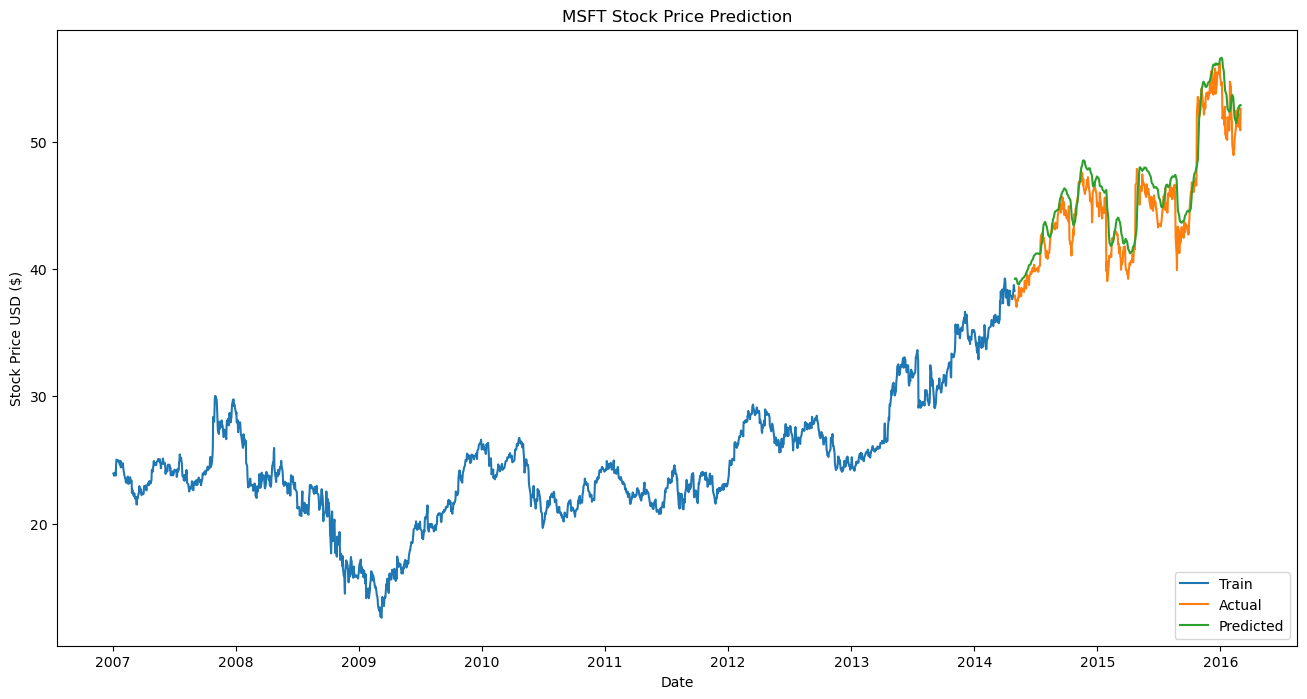

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
data = pd.read_csv('stockdata.csv')
data['Date'] = pd.to_datetime(data['Date'])

msft_data = data[['Date', 'MSFT']]
msft_data.set_index('Date', inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(msft_data)

train_data_len = int(len(scaled_data) * 0.8)

train_data = scaled_data[:train_data_len]
test_data = scaled_data[train_data_len - 60:]

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape the data to be 3-dimensional for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])


model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=1)


predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)


train = msft_data[:train_data_len]
valid = msft_data[train_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price USD ($)')
plt.plot(train['MSFT'])
plt.plot(valid[['MSFT', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predicted'], loc='lower right')
plt.show()
